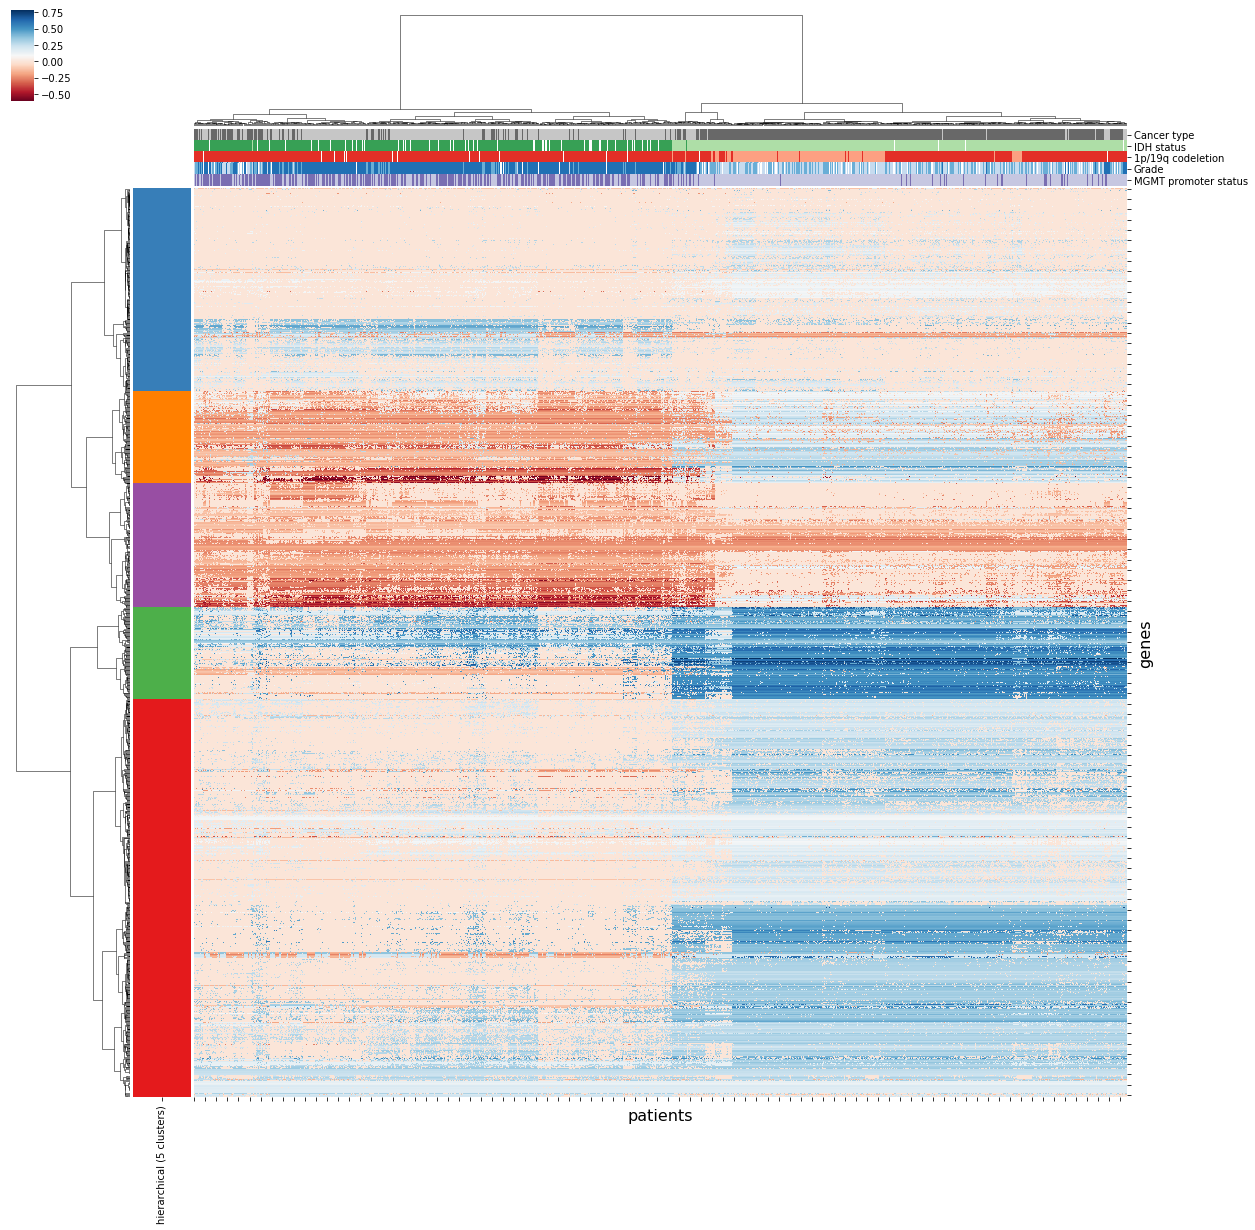

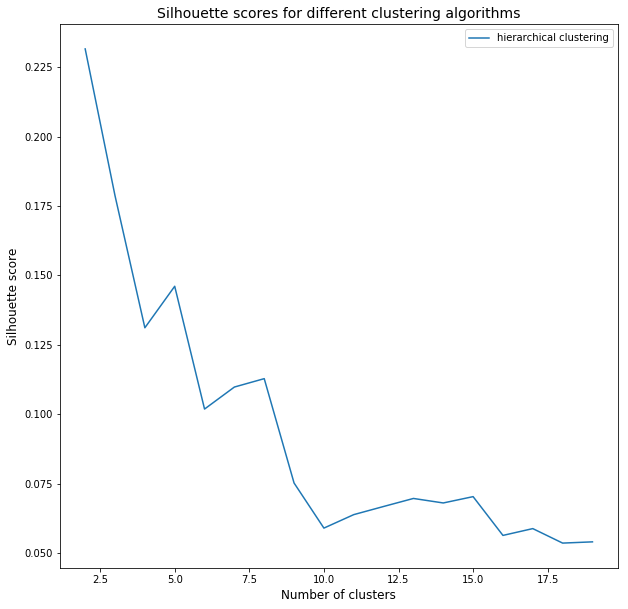

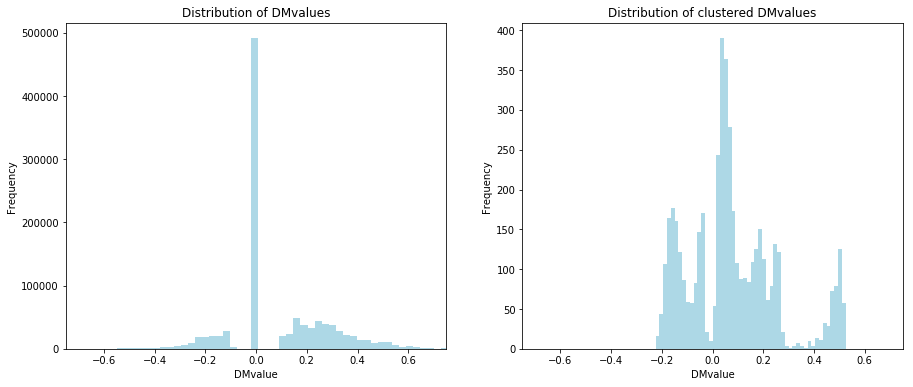

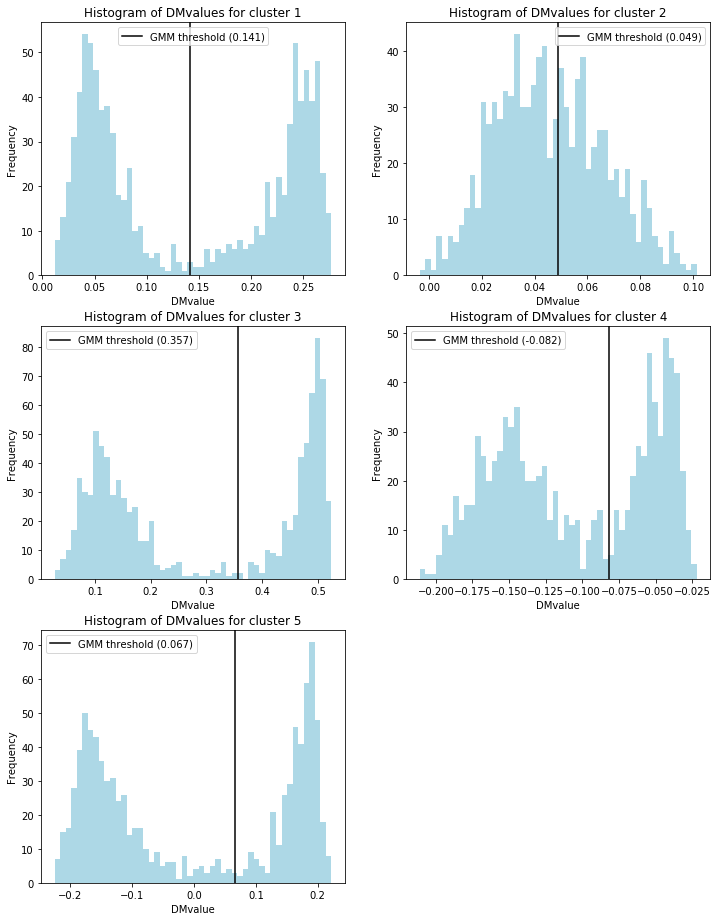

In [234]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from config import Config
from datasets import Dataset,DatasetML
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from collections import OrderedDict
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder

config = Config(clustering="hierarchical", source="LGGGBM", folder="Clusters", n_clusters=5, classifier= 'rf')
dataset = Dataset(config)
DMvalues = dataset.get_DMvalues()

#Clustered heatmap of the DMvalues
row_colors = OrderedDict()

#model = KMeans(n_clusters=config.n_clusters)
#labels_kmeans = model.fit_predict(DMvalues.T)


                       
                       
model = AgglomerativeClustering(n_clusters=config.n_clusters, affinity='euclidean', linkage='ward')
labels_hierarchical = model.fit_predict(DMvalues.T)

#row_colors["kmeans (%d clusters)"%config.n_clusters] = [sns.color_palette("YlGn", config.n_clusters)[label] for label in labels_kmeans]
row_colors["hierarchical (%d clusters)"%config.n_clusters] = [sns.color_palette("Set1", config.n_clusters)[label] for label in labels_hierarchical]                          
row_colors = pd.DataFrame(row_colors, index=DMvalues.columns)

col_colors = OrderedDict()

labels = np.load("inputs/case_labels.npy")
labels = [labels[labels[:,0] == index,:][0,1]=="LGG" for index in DMvalues.index]
col_colors["Cancer type"] = [sns.color_palette("Greys", 2)[label] for label in labels]
col_colors = pd.DataFrame(col_colors, index=DMvalues.index)

def supp_data(i, color):
    col_colors = OrderedDict()
    supp_data = pd.read_excel('TCGA Supp Data.xlsx', header=0,index_col=0)
    values = (list(DMvalues.T.columns))
    supp_data = supp_data.filter(values, axis = 0)
    supp_data = supp_data.loc[:,i].to_frame()
    NaN = supp_data[supp_data.isna().values == True]
    supp_data = supp_data[supp_data.isna().values == False].apply(LabelEncoder().fit_transform)
    labels = supp_data[i].values
    unique = len(np.unique(labels))
    col_colors[i] = [sns.color_palette(color, unique)[label] for label in labels]
    col_colors = pd.DataFrame(col_colors, index= supp_data.index)
    col_colors = pd.concat([NaN, col_colors])
    return col_colors

colors = ['Greens', 'Reds', 'Blues','Purples']
supps = ['IDH status', '1p/19q codeletion','Grade', 'MGMT promoter status']
for i in range(len(supps)):
    col_colors[supps[i]] = supp_data(supps[i],colors[i])

clust_map = sns.clustermap(data=DMvalues.T, method='ward', metric='euclidean', col_colors=col_colors, row_colors=row_colors, cmap = 'RdBu',  figsize=(20, 20))
#clust_map.ax_row_dendrogram.set_visible(False)
#clust_map.ax_col_dendrogram.set_visible(False)
clust_map.ax_heatmap.set_ylabel("genes", size=16)
clust_map.ax_heatmap.set_xlabel("patients", size=16)
clust_map.ax_heatmap.set_yticklabels([])
clust_map.ax_heatmap.set_xticklabels([])
clust_map.savefig('cluster.png')


#Optimal number of clusters
plt.figure(figsize=(10,10))
max_clusters = 20
#silhouette_scores_kmeans = []
#for n_clusters in range(2,max_clusters):
    #model = KMeans(n_clusters=n_clusters)
    #labels = model.fit_predict(DMvalues.T)
    #silhouette_scores_kmeans.append(silhouette_score(DMvalues.T, labels, metric='euclidean'))
silhouette_scores_hierarchical = []

for n_clusters in range(2,max_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    labels = model.fit_predict(DMvalues.T)
    silhouette_scores_hierarchical.append(silhouette_score(DMvalues.T, labels, metric='euclidean'))        
#plt.plot(range(2,max_clusters), silhouette_scores_kmeans, label="kmeans clustering")
plt.plot(range(2,max_clusters), silhouette_scores_hierarchical, label="hierarchical clustering")
plt.title("Silhouette scores for different clustering algorithms", size=14)
plt.xlabel("Number of clusters", size=12)
plt.ylabel("Silhouette score", size=12)
plt.legend()
plt.show()


#General Distribution of DMvalues
plt.figure(figsize=(15,6))   
plt.subplot(121)
plt.hist(DMvalues.values.flatten(), bins=50, color = 'lightblue')
plt.title("Distribution of DMvalues", size=12)
plt.xlabel("DMvalue", size=10)
plt.ylabel("Frequency", size=10)
plt.xlim([-0.75,0.75])
plt.subplot(122)
plt.hist(dataset.temp.values.flatten(), bins=50, color = 'lightblue')
plt.title("Distribution of clustered DMvalues", size=12)
plt.xlabel("DMvalue", size=10)
plt.ylabel("Frequency", size=10)
plt.xlim([-0.75,0.75])
plt.show()

#Distribution of DMvalues within each cluster
model = GaussianMixture(n_components=2)
fig = plt.figure(figsize=(12,27))
for i in range(config.n_clusters):
    plt.subplot(5,2,i+1)
    data = list(dataset.temp.values[:,i])
    data.sort()
    data = np.array(data).reshape((-1,1))
    model.fit(data)
    pred = model.predict(data)
    threshold = data[np.argmax(pred!=pred[0])][0]
    plt.hist(data, bins=50,color = 'lightblue')
    plt.axvline(x=threshold, c="black", label="GMM threshold (%.3f)"%threshold)
    plt.title("Histogram of DMvalues for cluster %d"%(i+1))
    plt.xlabel("DMvalue")
    plt.ylabel("Frequency")
    plt.legend()
plt.show()

In [236]:
model = AgglomerativeClustering(n_clusters=config.n_clusters, affinity='euclidean', linkage='ward')
labels_hierarchical = model.fit_predict(DMvalues.T)
df = pd.DataFrame(list(zip(list(DMvalues.columns),model.labels_ )), columns= ['Genes', 'Cluster']).set_index('Genes')

l = []
for gene in df.index:
    try:
        x = gene.split('-')
        l.append(x[0])
    except:
        x = gene
        l.append(x)
df.index = l


In [237]:
genes = {}
for i in np.unique(df.Cluster):
    genes[i] = list(df[df.Cluster == i].index)
pd.DataFrame.from_dict(genes, orient='index').T.replace([None], [''], regex=True).to_csv('genes.csv')

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17'],
      dtype='object', name='network')

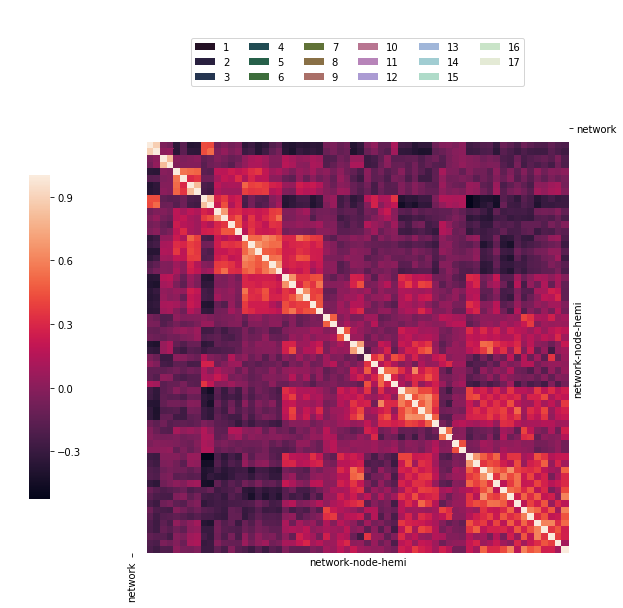

In [27]:

labels = np.load("inputs/case_labels.npy")
labels = [labels[labels[:,0] == index,:][0,1]=="LGG" for index in DMvalues.index]





#centers = model.cluster_centers_

networks = sns.load_dataset("brain_networks", index_col=0, header=[0, 1, 2])
network_labels = networks.columns.get_level_values("network")
network_pal = sns.cubehelix_palette(network_labels.unique().size,
                                    light=.9, dark=.1, reverse=True,
                                    start=1, rot=-2)

colors = ['Greens', 'Reds', 'Blues','Purples']
supps = ['IDH status', '1p/19q codeletion','Grade', 'MGMT promoter status']

network_lut = dict(zip(map(str, network_labels.unique()), network_pal))

network_colors = pd.Series(network_labels).map(network_lut)

g = sns.clustermap(networks.corr(),

                  # Turn off the clustering
                  row_cluster=False, col_cluster=False,

                  # Add colored class labels
                  row_colors=network_colors, col_colors=network_colors,

                  # Make the plot look better when many rows/cols
                  linewidths=0, xticklabels=False, yticklabels=False)

for label in network_labels.unique():
    g.ax_col_dendrogram.bar(0, 0, color=network_lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
                   
g.cax.set_position([.15, .2, .03, .45])
network_labels.unique()

Index(['1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '6', '6',
       '7', '7', '7', '7', '7', '7', '8', '8', '8', '8', '8', '8', '9', '9',
       '10', '10', '11', '11', '12', '12', '12', '12', '12', '13', '13', '13',
       '13', '13', '13', '14', '14', '15', '15', '16', '16', '16', '16', '16',
       '16', '16', '16', '17', '17', '17', '17', '17', '17', '17'],
      dtype='object', name='network')

In [ ]:
clust_map = sns.clustermap(data=DMvalues.T, method='ward', metric='euclidean', col_colors=col_colors, row_colors=row_colors, cmap = 'RdBu',  figsize=(20, 20))
#clust_map.ax_row_dendrogram.set_visible(False)
#clust_map.ax_col_dendrogram.set_visible(False)
clust_map.ax_heatmap.set_ylabel("genes", size=16)
clust_map.ax_heatmap.set_xlabel("patients", size=16)
clust_map.ax_heatmap.set_yticklabels([])
clust_map.ax_heatmap.set_xticklabels([])
clust_map.savefig('cluster.png')


In [70]:
DMvalues.columns

Index(['ABCA5---Cluster1', 'ABCC1', 'ABCC3---Cluster2', 'ABHD8---Cluster1',
       'ACAA2', 'ACADS---Cluster1', 'ACN9---Cluster1', 'ACOT4',
       'ACTC1---Cluster1', 'ACTG1',
       ...
       'ZNF214---Cluster1', 'ZNF300---Cluster2', 'ZNF502', 'ZNF542---Cluster2',
       'ZNF549---Cluster1', 'ZNF577', 'ZNF671', 'ZNF781---Cluster2',
       'ZSCAN12---Cluster1', 'ZSCAN18'],
      dtype='object', length=1147)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

DMvalues = dataset.get_DMvalues()
model = linkage(DMvalues, 'ward')

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(model, pdist(DMvalues))
c

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    model,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [10]:
config = Config()
dataset = DatasetML(config)

In [11]:
dataset.DMvalues

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
TCGA-DB-A4X9,1,0,1,1,1
TCGA-DB-A4XB,1,0,1,1,1
TCGA-FG-A4MT,1,0,1,1,1
TCGA-HT-A4DS,0,0,0,0,0
TCGA-DB-A4XD,1,0,1,1,1
TCGA-DB-A4XF,1,1,1,1,1
TCGA-DB-A4XG,1,1,1,1,1
TCGA-DB-A4XH,1,1,1,1,1
TCGA-HW-A5KK,0,0,0,0,0
TCGA-HW-A5KL,1,1,1,1,1
